In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score

from main_cl import Conv, AvgPool, Fullyconnected, MaxPooling, Flatten
from activations import Relu,Softmax, Sigmoid, Tanh
def categorical_cross_entropy(y_pred, y_true):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.sum(y_true * np.log(y_pred))

In [2]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = load_data(r'C:\Users\Aleks\Documents\Neura\laba2\dead_inside\data\3. mnist.npz')
mas = np.zeros((y_train.shape[0], 10)) 
for i, value in enumerate(y_train):
    mas[i, value] = 1 

In [3]:
def normalize_min_max(X):
    return (X - np.mean(X)) / np.std(X)
x_train = normalize_min_max(x_train)
x_train = x_train.reshape(x_train.shape[0], 1,x_train.shape[1],x_train.shape[2] )

In [4]:
class CNN:
    def __init__(self):
        self.conv1 = Conv(32, 5,5,1)
        self.pool1 = MaxPooling(5,5,2)
        self.tanh1 = Relu()
        self.conv2 = Conv(64, 5,5,32)
        self.pool2 = MaxPooling(5,5,2)
        self.relu2 = Relu()
        self.flatten= Flatten(64)
        self.fc1 = Fullyconnected(self.flatten.size, 10)
    def forward(self, X):
        out= self.conv1.forward(X)
        out= self.tanh1.forward(out)
        out = self.pool1.forward(out)
        out = self.conv2.forward(out)
        out = self.relu2.forward(out)
        out = self.pool2.forward(out)
        out = self.flatten.forward(out)
        out = self.fc1.forward(out)
        y_pred = Softmax().forward(out)
        return y_pred

    def train(self, X, y, epochs=1, batch_size=8, lr=1e-2):
        X = np.array(X) 
        y = np.array(y)
        n_samples = y.shape[0]
        epoch_losses = []
        train_costs = []
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            train_loss = 0
            train_acc = 0 
            pbar = tqdm(range(0, n_samples, batch_size))
            for start_idx in pbar:
                end_idx = min(start_idx + batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                y_pred = self.forward(X_batch)
                dout = self.backward(y_pred,y_batch)
                self._update_params(lr= lr)
                loss = categorical_cross_entropy(y_pred, y_batch) 
                train_loss += loss 
                train_acc += sum((np.argmax(y_batch, axis=1) == np.argmax(y_pred, axis=1)))
                pbar.set_postfix({'acc': train_acc, 'train_loss': train_loss})
            train_loss /= n_samples
            train_costs.append(train_loss)
            train_acc /= n_samples            
            print(f"Эпоха {epoch+1}/{epochs}, Средняя потеря: {train_loss}")
        return train_costs
    
    def backward(self, y_pred, y_batch):
        dout = y_pred - y_batch
        dout = self.fc1.backprop(dout)
        dout = self.flatten.backward(dout)
        dout = self.pool2.backward(dout)
        dout = self.relu2.backward(dout)
        dout = self.conv2.backward(dout)
        dout = self.pool1.backward(dout)
        dout = self.tanh1.backward(dout)
        dout = self.conv1.backward(dout)
        return dout
    
    def _update_params(self, lr):
        self.conv2._update_params()
        self.conv1._update_params()
        self.fc1.update_params()
       

In [5]:
c = CNN()
it = c.train(x_train, mas,batch_size = 16, epochs=30, lr=1e-5)

100%|██████████| 3750/3750 [03:24<00:00, 18.31it/s, acc=29758, train_loss=9.39e+4]


Эпоха 1/30, Средняя потеря: 1.5650693689214323


100%|██████████| 3750/3750 [03:19<00:00, 18.76it/s, acc=43686, train_loss=6.07e+4]


Эпоха 2/30, Средняя потеря: 1.012338170480306


100%|██████████| 3750/3750 [03:13<00:00, 19.34it/s, acc=44954, train_loss=6.55e+4]


Эпоха 3/30, Средняя потеря: 1.0924358886340035


100%|██████████| 3750/3750 [03:12<00:00, 19.46it/s, acc=45198, train_loss=7.26e+4]


Эпоха 4/30, Средняя потеря: 1.2099444880620083


100%|██████████| 3750/3750 [03:12<00:00, 19.45it/s, acc=45708, train_loss=8.05e+4]


Эпоха 5/30, Средняя потеря: 1.3412236527886807


100%|██████████| 3750/3750 [03:12<00:00, 19.52it/s, acc=44243, train_loss=9.83e+4]


Эпоха 6/30, Средняя потеря: 1.6386037202568804


100%|██████████| 3750/3750 [03:12<00:00, 19.44it/s, acc=44936, train_loss=1.04e+5]


Эпоха 7/30, Средняя потеря: 1.7340979378715804


100%|██████████| 3750/3750 [03:12<00:00, 19.47it/s, acc=45781, train_loss=1.11e+5]


Эпоха 8/30, Средняя потеря: 1.8563587850644498


100%|██████████| 3750/3750 [03:13<00:00, 19.35it/s, acc=46368, train_loss=1.18e+5]


Эпоха 9/30, Средняя потеря: 1.9740901585743675


 95%|█████████▍| 3562/3750 [03:06<00:09, 19.07it/s, acc=44407, train_loss=1.25e+5]


KeyboardInterrupt: 

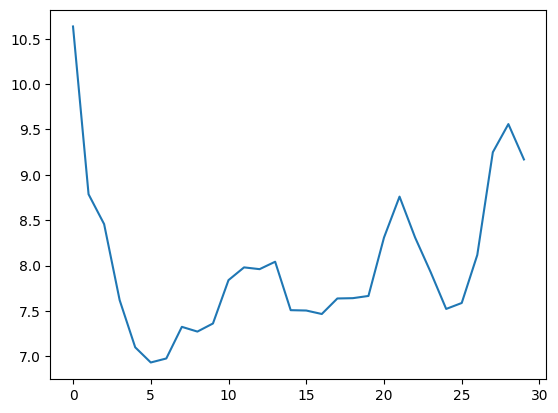

In [6]:
plt.plot(it)

In [13]:
c = CNN()
l = np.load('data/my_dict.npz', allow_pickle=True)
ls = {key: l[key] for key in l }
c.conv1.w = ls['self.conv1'].tolist()['W']
c.conv1.bias = ls['self.conv1'].tolist()['b']
c.conv2.w = ls['self.conv2'].tolist()['W']
c.conv2.bias = ls['self.conv2'].tolist()['b']
c.fc1.W = ls['self.fc1'].tolist()['W']
c.fc1.b = ls['self.fc1'].tolist()['b']

In [14]:
x_test_ = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
x_test_ = normalize_min_max(x_test_)
y = c.forward(x_test_)

ValueError: operands could not be broadcast together with shapes (10000,576,32) (32,1) 

In [8]:
y = np.argmax(y, axis=1)

In [9]:
def confusion_matrix_(y_true, y_pred, labels):
    conf_mat = np.zeros((len(labels), len(labels)), dtype=int)
    for y_true, y_pred in zip(y_true, y_pred):
        conf_mat[y_true, y_pred ] += 1
    return conf_mat

def metrics(cm, labels_am, y_pred ):
    tp =  np.diagonal(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn) 
    accuracy = (tp + tn) / np.sum(cm)
    F1 = 2*precision*recall/(precision+recall)    
    return pd.DataFrame({'Accuracy':accuracy,
                         'Precision':precision,
                         'Recall': recall,
                         'F1': F1})

def roc_curve(y_pred, y_true):
    tpr = []
    fpr = []
    for i in range(2):
        y_pred_ = y_pred[:,i]
        y_true_ = y_true[:,i]
        tresholds = sorted(y_pred_, reverse = True)
        tpr_ = []
        fpr_ = []
        positive = sum(y_true_)
        negative = y_true_.shape[0] - positive
        for tr in tresholds:
            y_calc_tr = np.array([1 if j >= tr else 0 for j in y_pred_])
            tp = np.sum((y_true_ == 1) & (y_calc_tr == 1))
            fp = np.sum((y_true_ == 0) & (y_calc_tr == 1))
            tpr_.append(tp/positive)
            fpr_.append(fp/negative)
        tpr.append(tpr_)
        fpr.append(fpr_)
    return tpr, fpr



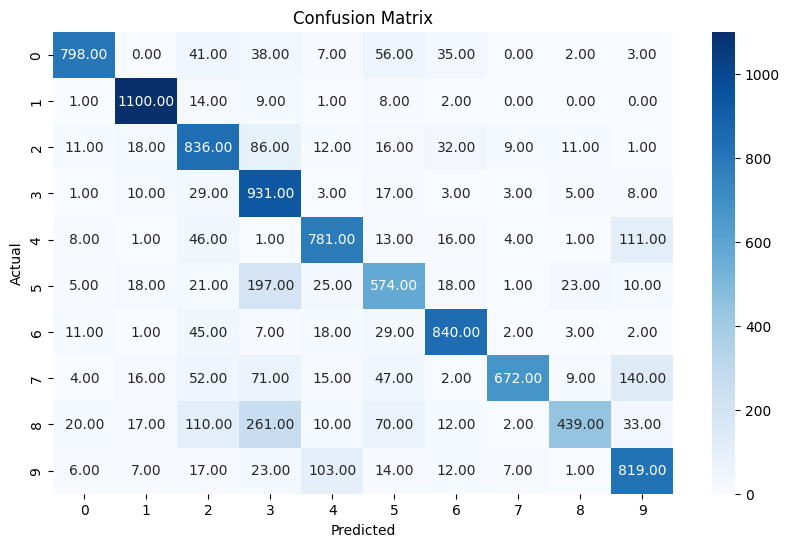

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 
cm = confusion_matrix_(y_test, y, labels=range(0,10))
np.set_printoptions(suppress=True)
figsize = (10,6)
fig, ax = plt.subplots(figsize=figsize)
plt.title('Confusion Matrix')
hmap = sns.heatmap(cm, ax=ax, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [11]:
metrics(cm, range(0,10), y)

,Accuracy,Precision,Recall,F1
0,0.9751,0.922543,0.814286,0.865041
1,0.9877,0.925926,0.969163,0.947051
2,0.9429,0.690339,0.810078,0.745430
3,0.9228,0.573276,0.921782,0.706910
4,0.9605,0.801026,0.795316,0.798160
5,0.9412,0.680095,0.643498,0.661290
6,0.9750,0.864198,0.876827,0.870466
7,0.9616,0.960000,0.653696,0.777778
8,0.9410,0.888664,0.450719,0.598093
9,0.9502,0.726708,0.811695,0.766854
